# Gender and Testimony - Extracting Language Patterns with spaCy

### The Ongoing Problem of Data-Driven Text Analysis

The process of extracting meaningful language patterns poses underlying challenges for any data-driven textual analysis. Here, this challenge is imagined as two-fold: analysts must determine which patterns are "meaningful" and analysts must apply the appropriate methods and tools to extract these meaningful patterns.

Analysts must also match guiding questions with an appropriate technique. They must be observant to how the methods and tools used to measure a corpus also give shape to the corpus and our analysis.

The purpose of this Notebook is thus to engage with this two-fold problem while text mining with spaCy NLP. 

In this exercise we will text mine a sample of the 2008 Subreddits: Worldnews, News, and Politics with the purpose of analyzing word co-occurance of grammatical gendered pronoun-verb pairs. These pairs are not necessarily consecutive, like bigrams, but instead share syntactic relations in a sentence.

This Notebook will ask a high-level, guiding question about gender: what kinds of actions are associated with male and female pronouns in this data set? 

### Getting Started

First import spaCy.

In [1]:
import spacy, warnings; warnings.simplefilter('ignore')
import pandas as pd

spaCy's language model can be loaded with `spacy.load()`. `spacy.load()` returns a `Language` object with the components and data required to process text such as a tagger and a tokenizer. 

For convention's-sake we will call our `Language` object `nlp`.

In [2]:
nlp = spacy.load('en_core_web_sm')

### Loading the Reddit data

The following code reads our sample into a pandas DataFrame.

In [3]:
%%time
reddit_sample_he_she = pd.read_csv("/scratch/group/history/hist_3368-jguldi/reddit_2008_he_she.csv")

CPU times: user 70.5 ms, sys: 9.05 ms, total: 79.6 ms
Wall time: 85.6 ms


In [4]:
reddit_sample_he_she

,body,subreddit
0,theres a difference between subtle tasteful ad...,politics
1,to make a point he doesnt want to just win he ...,politics
2,why the fuck isnt he in jail yet,politics
3,their futility even if the election comes off ...,politics
4,gtshes a menace to democracy and i guarantee w...,politics
...,...,...
15918,this man deserves the highest medal that great...,worldnews
15919,his name is supernovan he got the surname jenk...,politics
15920,i pointed out women because most of the time t...,politics
15921,you should know by now that youre going to get...,politics


After reading our sample, we can transform it into a pandas series object for quicker processing. Please note that in doing so, we loose the "subreddit" column, which leaves us with just the text of the subreddits.

In [5]:
reddit_sample_he_she_text = reddit_sample_he_she['body'].copy()

In [6]:
reddit_sample_he_she_text

0        theres a difference between subtle tasteful ad...
1        to make a point he doesnt want to just win he ...
2                         why the fuck isnt he in jail yet
3        their futility even if the election comes off ...
4        gtshes a menace to democracy and i guarantee w...
                               ...                        
15918    this man deserves the highest medal that great...
15919    his name is supernovan he got the surname jenk...
15920    i pointed out women because most of the time t...
15921    you should know by now that youre going to get...
15922    politicians have been using television and a b...
Name: body, Length: 15923, dtype: object

### Parsing Text with spaCy

As demonstrated in [Klein's Notebook](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb), invoking `nlp` on a string of text will return a processed `Doc` object. Within each `Doc` object is a spaCy `token` object. From these `token` objects we can access a word's lemmatized form, its part-of-speech, and other attributes.

Unlike Klein's data, however, ours is in a series object where each row is a string of text. We must iterate through each row of the data frame with `nlp.pipe()`, which processes the data in small batches. To improve parsing time we can disable features that we will not use for this exercise like named entity recognition (or `ent`).

In [7]:
%%time
reddit_sample_he_she_text = list(nlp.pipe(reddit_sample_he_she_text, disable = ["ent"]))

CPU times: user 1min 52s, sys: 18.8 s, total: 2min 10s
Wall time: 2min 11s


In [8]:
reddit_sample_he_she_text

[theres a difference between subtle tasteful ads and ones that jump in your face and dare you to close them somebody needs to do an afterschool special where the kid wishes internet advertising would disappear and when he wakes up the whole internet is gone but this is what you wanted billy those ads paid for all that wonderful content you enjoyed,
 to make a point he doesnt want to just win he wants to destroy mcbush aristocracy,
 why the fuck isnt he in jail yet,
 their futility even if the election comes off without a hitch and obama wins nothing will change hes from the democratic party the democratic party has been in power in congress for awhile and they have not rescinded a single policy enacted by the republicans not one after 911 the only necessaryt hing that needed to be done to guarantee that there was never an attack such as it was to implement bulletproof cockpit doors thats it everything else was a move to fascism and an unreasonable usurpation of power by the government 

`reddit_sample_he_she_text` looks just like any other list, but it is actually a spaCy `doc` object where every word is a spaCy `token` object. We will explore the objects' attributes in the following section. 

### Processing spaCy `token` Objects for Part-of-Speech Extraction

For our analysis, we are just interested in the spaCy `token` objects inside the `doc` object. The `token` objects include attributes such as:

 - `.text`: the original word
 - `.lemma_`: the word's lemmatized form
 - `.pos_`: the word's part-of-speech
 - `.dep_`: the word's syntactic dependency
 - `.head.text`: the word upon which the present word is dependent

These attributes can be viewed by iterating through each `doc` object like the following code:

In [9]:
def extractTokens(spacy_doc_object):
    spacy_tokens = []
    for doc in spacy_doc_object:
        for token in doc:
            row = (token.text, token.lemma_, token.pos_, token.dep_, token.head.text)
            spacy_tokens.append(row)
    return spacy_tokens

reddit_tokens = extractTokens(reddit_sample_he_she_text)

In [10]:
reddit_tokens[:30]

[('there', 'there', 'PRON', 'expl', 's'),
 ('s', 's', 'VERB', 'ROOT', 's'),
 ('a', 'a', 'DET', 'det', 'difference'),
 ('difference', 'difference', 'NOUN', 'attr', 's'),
 ('between', 'between', 'ADP', 'prep', 'difference'),
 ('subtle', 'subtle', 'ADJ', 'amod', 'ads'),
 ('tasteful', 'tasteful', 'ADJ', 'amod', 'ads'),
 ('ads', 'ad', 'NOUN', 'pobj', 'between'),
 ('and', 'and', 'CCONJ', 'cc', 'ads'),
 ('ones', 'one', 'NOUN', 'conj', 'ads'),
 ('that', 'that', 'DET', 'nsubj', 'jump'),
 ('jump', 'jump', 'VERB', 'relcl', 'ads'),
 ('in', 'in', 'ADP', 'prep', 'jump'),
 ('your', '-PRON-', 'DET', 'poss', 'face'),
 ('face', 'face', 'NOUN', 'pobj', 'in'),
 ('and', 'and', 'CCONJ', 'cc', 'jump'),
 ('dare', 'dare', 'VERB', 'conj', 'jump'),
 ('you', '-PRON-', 'PRON', 'dobj', 'dare'),
 ('to', 'to', 'PART', 'aux', 'close'),
 ('close', 'close', 'VERB', 'xcomp', 'dare'),
 ('them', '-PRON-', 'PRON', 'dobj', 'close'),
 ('somebody', 'somebody', 'PRON', 'nsubj', 'needs'),
 ('needs', 'need', 'VERB', 'ccomp', 'clo

Before continuing, let's take a moment to observe the output of `reddit_tokens`.

`reddit_tokens` is split into one token per row. Alongside each token is: a) the token, b) the token's lemmatized form, c) the tokens part-of-speech, d) the token's syntactic function, and e) the token's "head", or the token to which it syntactically depends.

### Extracting Parts-of-Speech from Parsed Reddit Text

Now we can begin extracting grammatical parts-of-speech for the purpose of looking for language trends. The following code extracts grammatical pairs where the subject is tagged as a noun subject or passive noun subject, and is also a "child" of a verb. 

The verb is lemmatized to prevent counting inflectional verbs separately from their base form.

In [11]:
from spacy.symbols import nsubj, nsubjpass, VERB

def extractPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for subject in doc:
            if subject.dep == nsubj or subject.dep == nsubjpass and subject.head.pos == VERB:
                extracted_pairs = subject.text, subject.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

pairs = extractPairs(reddit_sample_he_she_text)

In [12]:
pairs[:30]

['that jump',
 'somebody need',
 'kid wish',
 'advertising disappear',
 'he wake',
 'this be',
 'you want',
 'ads pay',
 'you enjoy',
 'he want',
 'he want',
 'fuck be',
 'he be',
 'futility win',
 'election come',
 'nothing change',
 'he s',
 'party be',
 'they rescind',
 'hing be',
 'that need',
 'it be',
 'that s',
 'he be',
 'he do',
 'public like',
 'it be',
 'that give',
 'it be',
 'that put']

`pairs` is a list subjects followed by verbs.

For the sake of counting and matching with words regardless of case, we can transform all words to lower case.

In [13]:
lowercase_pairs = [word.lower() for word in pairs]

In [14]:
lowercase_pairs[:30]

['that jump',
 'somebody need',
 'kid wish',
 'advertising disappear',
 'he wake',
 'this be',
 'you want',
 'ads pay',
 'you enjoy',
 'he want',
 'he want',
 'fuck be',
 'he be',
 'futility win',
 'election come',
 'nothing change',
 'he s',
 'party be',
 'they rescind',
 'hing be',
 'that need',
 'it be',
 'that s',
 'he be',
 'he do',
 'public like',
 'it be',
 'that give',
 'it be',
 'that put']

<div class="alert alert-block alert-info">
Remember to capitalize I before turning in your paper.
</div>

We can narrow these results to just pairs containing gendered pronouns for the purpose of exploring our guiding question: what kinds of actions are associated with male and female pronouns in the decade 1870?

### Filtering for Gendered Pronoun-Verb Pairs

The goal of this Notebook is to extract gendered pronoun-verb pairs and create visualizations that compare male pronoun-verb pairs and female pronoun-verb pairs. First, however, we will just extract pairs with the pronoun he.

We can search for "he" and its grammatical verbs by treating "he" as a regular expression (or sequence of characters that define a search pattern). The following code defines our regular expression, `('he ')`, and creates a variable for each pair that contains a match.

In [15]:
import re

def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

In [16]:
male[:30]

['he wake',
 'he want',
 'he want',
 'he be',
 'he s',
 'he be',
 'he do',
 'he be',
 'he be',
 'he be',
 'he say',
 'he will',
 'he bear',
 'he tend',
 'he talk',
 'he be',
 'he make',
 'he put',
 'he mean',
 'he do',
 'he miss',
 'he s',
 'he s',
 'he need',
 'he do',
 'he s',
 'he s',
 'he s',
 'he need',
 'he do']

Viewing just the first 30 lines of our lists shows us that our gendered pronoun-verb pairs contain stop words like be or say. Pairs containing a stop word can be removed. 

We can do this by first defining our stop words . . . 

In [17]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest', 's']

. . . and then matching this list with our pairs to see whether any tokens match a stop word.

The following code removes stop words by a) splitting the pair into individual tokens, b) creating a variable, `tokens_filtered` for just words that do not match a stop word, and c) joining indiviudal words back together to make a pair.

In [18]:
tokens_joined = []

for pair in male:
    tokens = pair.split(" ")
    tokens_filtered = [word for word in tokens if not word in stopwords]
    tokens = " ".join(tokens_filtered)
    tokens_joined.append(str(tokens))

In [19]:
tokens_joined[:30]

['he wake',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he bear',
 'he tend',
 'he talk',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he miss',
 'he',
 'he',
 'he need',
 'he',
 'he',
 'he',
 'he',
 'he need',
 'he']

We have a problem, however. After joining the individual words we are left with messy data: some strings only have one word because the other word was removed. 

We can remove these individual tokens by writing a line of logic that only keeps strings that are the length of two (i.e. strings that are pairs). 

In [20]:
def removeStopWords(pairs):
    keep_pairs = []
    for pair in pairs:
        tokens = pair.split(" ")
        tokens_filtered = [word for word in tokens if not word in stopwords]
        joined_tokens = " ".join(tokens_filtered)
        if len(tokens_filtered) == 2: # if string is length of two
            keep_pairs.append(str(joined_tokens)) # keep the string
    return keep_pairs

male_no_stopwords = removeStopWords(male)

In [21]:
male_no_stopwords[:30]

['he wake',
 'he bear',
 'he tend',
 'he talk',
 'he miss',
 'he need',
 'he need',
 'he figure',
 'he ban',
 'he face',
 'he write',
 'he joke',
 'he try',
 'he likei',
 'he misrepresent',
 'he lie',
 'he try',
 'he hate',
 'he judge',
 'he bear',
 'he blather',
 'he cancel',
 'he figure',
 'he break',
 'he post',
 'he rs',
 'he win',
 'he sell',
 'he hand',
 'he earn']

### Counting Gendered Pronoun-Verb Pairs

After aggregating gendered pronouns that syntactically depend on a verb, we can count their frequency.

The following code defines a function, `countWords()`, that creates a dictionary of every unique pair and its frequency. Any pair not already in the dictionary is added. If the pair is already part of the dictionary its count increments by 1.

In [22]:
def countWords(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict
            
male_dictionary = countWords(male_no_stopwords)

In [23]:
for kv in list(male_dictionary)[:30]:
    print(kv,  male_dictionary[kv])

he wake 11
he bear 95
he tend 5
he talk 168
he miss 14
he need 229
he figure 10
he ban 5
he face 9
he write 101
he joke 9
he try 204
he likei 1
he misrepresent 4
he lie 62
he hate 29
he judge 3
he blather 2
he cancel 1
he break 32
he post 60
he rs 1
he win 274
he sell 38
he hand 12
he earn 19
he elect 96
he avoid 6
he run 173
he conduct 4


Dictionaries do not store data in sequential order. This is because a dictionary is "hashable," and not linear like a list. While this makes dictionaries quick to process, its organization is not conducive to analysis.

Therefore, we will cast the pronoun-verb pairs and their counts to a pandas DataFrame.

In [24]:
male_pronoun_verb_counts = pd.DataFrame(male_dictionary.items(),columns = ['Pair','Count'])

In [25]:
male_pronoun_verb_counts

,Pair,Count
0,he wake,11
1,he bear,95
2,he tend,5
3,he talk,168
4,he miss,14
...,...,...
1518,he rail,1
1519,he oil,1
1520,he validate,1
1521,he immigrate,1


After creating a pandas DataFrame with our pronoun-verb pairs we can arrange the frequency counts so pairs with the highest count are first.

In [26]:
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

In [27]:
male_pronoun_verb_counts

,Pair,Count
22,he win,274
5,he need,229
11,he try,204
76,he vote,181
28,he run,173
...,...,...
922,he recite,1
923,he surprise,1
924,he transcrip,1
926,he assist,1


<div class="alert alert-block alert-info">
Before we continue: one concern had by students was whether it is possible to save variables so that we would not have to rerun spaCy. The answer is: yes, but we need to be mindful of the variable's data structure. During points in our code we can transform our data structure (our dictionary, our list, etc.) to a pandas DataFrame and save the pandas DataFrame to a CSV file. A CSV file looks like an Excel spreadsheet and can be easily read back into your code. The following commented-out example shows how to save a CSV file and then read it back into your Notebook.
</div>

In [28]:
# male_pronoun_verb_counts.to_csv('male_pronoun_verb_counts.csv') # save your variable to a CSV file on disk
# loaded_male_pronoun_verb_counts = pd.read_csv('male_pronoun_verb_counts.csv') # load your CSV file 

### Visualizing our Results for Analysis

We are now ready to visualize our results: grammatical pronoun-verb pairs that show us which verbs are commonly associated with the pronoun he in our Reddit sample of "Worldnews," "News," and "Politics."

The following code takes a subset of the first 25 rows of `male_pronoun_verb_counts`.

In [29]:
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

In [30]:
top_male_pronoun_verb_counts

,Pair,Count
22,he win,274
5,he need,229
11,he try,204
76,he vote,181
28,he run,173
3,he talk,168
32,he lose,144
149,he look,128
48,he start,125
37,he choose,116


These top grammatical pairs can now be visualized with matplotlib. 

The following code imports matplotlib, sets the plot's size, and renders the visualization.

In [31]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 10]

top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

<AxesSubplot:title={'center':'Top Grammatical Pronoun-Verb Pairs with He: Searching the Worldnews, Politics, and News Subreddits'}, ylabel='Pair'>

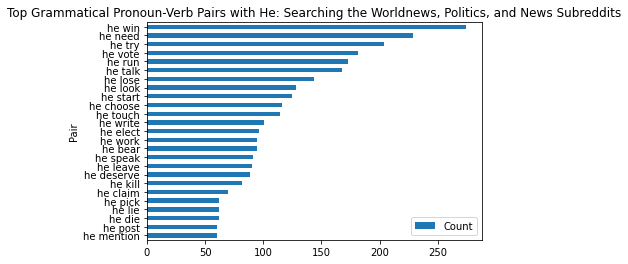

In [32]:
top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching the Worldnews, Politics, and News Subreddits")

### Reiterating the Process to Extract Female Grammatical Pronouns and their Verbs 

We can reiterate the same process outlined above to extract the pronoun she and its grammatical verbs. The following code defines one new function (to extract female pronoun-verb pairs) and then calls our already defined functions to render a bar graph of top pairs.

<AxesSubplot:title={'center':'Top Grammatical Pronoun-Verb Pairs with She: Searching the Worldnews, Politics, and News Subreddits'}, ylabel='Pair'>

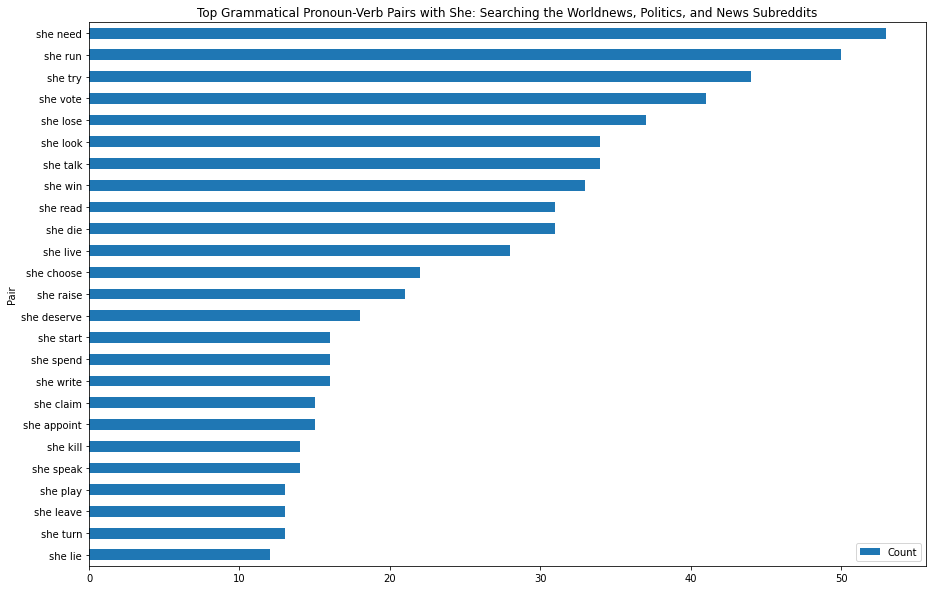

In [33]:
# extract grammatical pronoun-verb pairs where she is subject
def extractFemalePairs(pairs):
    regex = re.compile('she ')
    female = [word for word in lowercase_pairs if regex.match(word)]
    return female

female = extractFemalePairs(lowercase_pairs)

# remove stop words
female_no_stopwords = removeStopWords(female)

# create a dictionary with each unique pair and its frequency
female_dictionary = countWords(female_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_pronoun_verb_counts = pd.DataFrame(female_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_pronoun_verb_counts = female_pronoun_verb_counts[:25].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with She: Searching the Worldnews, Politics, and News Subreddits")

### Assignment Rules

1. extract and visualize lemmatized, gendered adjective-noun pairs (i.e. women, man + their adjectives) from the same subset of the Reddit data.

    - Note: you can accomplish this task by modifying the pre-existing code in _this Notebook_. 

2. Write down four observations based on your visualizations.

3. Write a paragraph describing how you could continue to mine Reddit for results that would yield a more meaningful and sophisticated analysis.

    - For example, you could say: "my research focused on "X, Y, and Z" but a more sophisticated analysis might also ask: "A, B, and C." 

### Getting Started on Your Assignment

To keep our data sets small, you can read in another subset of the Reddit data which includes just sentences with the word "man" or "woman." 

In [34]:
reddit_man_woman_corpus = pd.read_csv("/scratch/group/history/hist_3368-jguldi/reddit_2008_he_she.csv")

reddit_man_woman_corpus_text = reddit_man_woman_corpus['body'].copy()

reddit_man_woman_corpus_text = list(nlp.pipe(reddit_man_woman_corpus_text, disable = ["ent"]))

As mentioned, you can modiy the code in this Notebook to extract female adjective-noun pairs. To see what I mean, let's get started on this problem together.

We know we already have functions that count pairs, create DataFrames, and visualize our results. Therefore, we just need to change the code that determines which pairs are extracted. Instead of extracting noun-verb pairs we want to extract adjective-noun pairs. 

So, let's return to the `extractPairs()` function and modify it for our assignment. Instead of using the symbols `nsubj` (for noun subject), `nsubjpass` (for passive noun subject) and `VERB`, we will use `amod` (for adjectival modifier), `acomp` (for adjectival complement), and `NOUN`. 

In [35]:
from spacy.symbols import amod, acomp, NOUN

def extractAdjNounPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for adjective in doc:
            if adjective.dep == amod or adjective.dep == acomp and adjective.head.pos == NOUN: # or adjective.dep == ccomp or adjective.dep == conj 
                extracted_pairs = adjective.text, adjective.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

adjective_noun_pairs = extractAdjNounPairs(reddit_man_woman_corpus_text)

In [36]:
adjective_noun_pairs[:30]

['subtle ad',
 'tasteful ad',
 'whole internet',
 'wonderful content',
 'democratic party',
 'democratic party',
 'single policy',
 'only hing',
 'such be',
 'bulletproof door',
 'unreasonable usurpation',
 'close election',
 'stolen election',
 'lame duck',
 'demcoratic party',
 'third party',
 'farfetched thing',
 'coming year',
 'next election',
 'national spotlight',
 'quiet alaska',
 'republican process',
 'own colleague',
 'liberal elitist',
 'senior republican',
 'full republican',
 'faux outrage',
 'black look',
 'antiislamic propaganda',
 'correct yaf']

Like our previous code, we can transform each pair to lower case so the same word with a different case is not counted separately. In other words, we don't want to count "Woman" and "woman" separately.

In [37]:
lowercase_adjective_noun_pairs = [word.lower() for word in adjective_noun_pairs]

Now instead of extracting pairs with the regular expression "she " we can extract pairs with the regular expression " woman."

In [38]:
def extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile(' woman')
    female = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return female

female_adj_noun_pairs = extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [39]:
female_adj_noun_pairs[:30]

['insane woman',
 'republican woman',
 'straight woman',
 'stupid woman',
 'illiterate woman',
 'dumb woman',
 'different woman',
 'attractive woman',
 'attractive woman',
 'tiny woman',
 'afraid woman',
 'adirty woman',
 'white woman',
 'sick woman',
 'sick woman',
 'good woman',
 'developed woman',
 'private woman',
 'private woman',
 'black woman',
 'most woman',
 'muslim woman',
 'pregnant woman',
 'beautiful woman',
 'many woman',
 'outgoing woman',
 'young woman',
 'young woman',
 'old woman',
 'designated woman']

We can now use our functions to count and visualize our data.

<AxesSubplot:title={'center':'Top Grammatical Adjective-Noun Pairs with Woman: Searching the Worldnews, Politics, and News Subreddits'}, ylabel='Pair'>

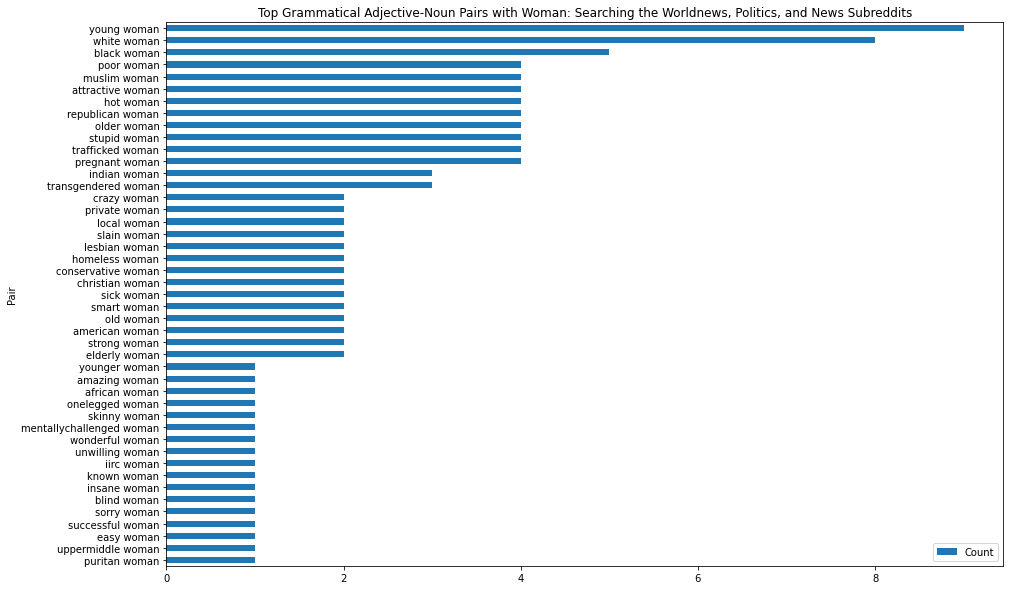

In [40]:
# remove stop words
female_adj_noun_pairs_no_stopwords = removeStopWords(female_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
female_adj_noun_dictionary = countWords(female_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_adj_noun_df = pd.DataFrame(female_adj_noun_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_adj_noun_counts = female_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_adj_noun_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Adjective-Noun Pairs with Woman: Searching the Worldnews, Politics, and News Subreddits")

Now it's your turn to finish the assignment by repeating the process for "man" and answering the rest of the questions listed in the __Assignment Rules__ section.